# Proyecto 1: Etapa 1 - Inteligencia de negocios

**Nicolas Camargo - 202020782**

**Pablo Pedreros - 202112491**

**Jairo Garavito Correa - 202111499**

# Problema
Con fin de apoyar el objetivo de estos agentes del sector de turismo en Colombia, de lograr establecer un analisis sobre un conjunto de reseñas turisticas y las respectivas calificaciones dadas por los clientes, se establecerá un modelo de clasificación en base a la analítica de estos textos, con técnicas de aprendizaje y de procesamiento de lenguaje natural que logren de buena forma relacionar la reseña con su respectiva calificación y generar un modelo predictivo para la calificación de datos nuevos.

# 1. Importacion de librerias

In [105]:
 # Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [106]:
# Manejo de gráficas
!pip install scikit-plot
# Instalar perfilamiento en pandas
!pip install ydata-profiling


In [107]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [108]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [110]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
import statistics

import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

# 2. Perfilamiento y entendimiento de los datos

En primer lugar, realizamos la carga de los dos archivos, de los cuales podemos identificar como contamos con una partición de prueba la cual no contiene los datos etiquetados, donde no encontramos la columna "Class" que otorga la calificacion correspondiente a la review en la partición original de entrenamiento.

In [111]:
df = pd.read_csv('tipo1_entrenamiento_estudiantes.csv', delimiter=',')

dfData = df
dfData

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2
...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3
7871,Es difícil revisar el castillo porque apenas p...,3
7872,Si vas a Mérida no puedes perderte de este lug...,5
7873,"Este imperdible sitio, que lleva el nombre del...",5


Ahora hacemos uso de la funcion value_counts() con el fin de ver los posibles valores que toman las resenas y vemos como estos van en un rango de 1-5, lo cual, es congruente con el problema planteado. No hay invalidez en este sentido.

In [112]:
count = dfData['Class'].value_counts()
print(count)

Class
5    2350
4    1971
3    1568
2    1173
1     813
Name: count, dtype: int64


Ahora realizamos la vista estadistica de los datos y realizamos un perfilamiento completo con la librería de ydata-profiling, que nos permite ver todas las estadísticas y valores repetidos, entre otros:

In [113]:
from ydata_profiling import ProfileReport
info = dfData.copy()

info['Conteo'] = [len(x) for x in info['Review']]
info['Moda'] = [[statistics.mode([len(x) for x in i.split(' ')])][0] for i in info['Review']]
info['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in info['Review']]
info['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in info['Review']]

ProfileReport(info)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ahora realizamos una observación de duplicados en el set:

In [114]:
dfData.duplicated().sum()

71

Como se observa tenemos datos duplicados, tendremos que realizar una limpieza de estos, posiblemente eliminando estos duplicados pues e simprobable que sean datos correctos.

Ademas, observamos el tipo de dato para las columnas del conjunto. Como podemos ver, para review contamos con que es tipo objeto y la class que es la calificacion tiene un tipo int.

In [115]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [116]:
dfData.describe

<bound method NDFrame.describe of                                                  Review  Class
0     Nos alojamos en una casa alquilada en la ciuda...      4
1     La comida está bien, pero nada especial. Yo te...      3
2     En mi opinión, no es una como muchos usuarios ...      3
3     esta curiosa forma que asemeja una silla de mo...      4
4     Lo mejor era la limonada. Me gusto la comida d...      2
...                                                 ...    ...
7870  El motivo de mi estancia fue porque vine a un ...      3
7871  Es difícil revisar el castillo porque apenas p...      3
7872  Si vas a Mérida no puedes perderte de este lug...      5
7873  Este imperdible sitio, que lleva el nombre del...      5
7874  Festejando Dia del Amor y Amistad\n\nTe remont...      3

[7875 rows x 2 columns]>

Contamos con cero valores nulos en el conjunto, como se observa a continuación

In [117]:
dfData.isnull().sum()

Review    0
Class     0
dtype: int64

# 3. Preparación de datos

## 3.1 Limpieza de datos

Realizaremos la limpieza de datos en este caso haciendo uso de las siguientes funciones que se aplicarán posteriormente junto con la tokenización con el fin de eliminar cierto ruido de que pueden tener los datos y asi tener más limpia la base sobre la cual construir los modelos de analisis de texto. Empezaremos eliminando los duplicados:

In [118]:
dfData.drop_duplicates(inplace=True)

En primer lugar para el preprocesamiento, eliminamos todos los caracteres que no sean ASCII puesto que esto no nos permitira realizar un analisis coherente posteriormente de las palabras que afectan a la calificacion.

In [119]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

Ahora, realizamos la funcion to_lowercase() con el fin de convertir todas las palabras de los datos a minusculas, lo cual es común en el procesamiento de textos para que todas las palabras, sean minúsculas o mayúsculas originalmente, tengan el mismo peso final en la evaluación.

In [120]:
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()  # Convierte la palabra a minúsculas
        new_words.append(new_word)
    return new_words

Para esta función, eliminamos toda puntuación que no aporta realmente en nada y simplemente queda el espacio libre, quitando así puntos, comas, etc.

In [121]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Realizamos finalmente, la funcion de remover stopwords, o palabras vacias en espanol, las cuales no tienen mayor peso pues son mas comunicativas que explicativas en la reseña, por ejemplo, palabras como: a, al, algo, ahí, de, entre otros.

In [122]:
def remove_stopwords(words):
    stop_words = set(stopwords.words('spanish'))
    new_words = [word for word in words if word.lower() not in stop_words]
    return new_words

Ahora simplemente, juntamos todas las funciones descritas anteriormente una funcion de preprocesamiento, la cual usaremos en la tokenización para limpiar estos datos y tokenizarlos al tiempo.

In [123]:
def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [124]:
total_rows = dfData.shape[0]
total_rows

7804

## 3.2 Tokenización

En este paso, realizaremos la tokenización de cada review por palabras, dividiendo asi todo el texto, lo cual nos ayuda en la posterior clasificación de cada review en una nota dada. De este mismo modo, implementaremos al tiempo la limpieza de datos gracias a la aplicacion de la función preprocessing, por lo cual, de esta lista de tokens (palabras) extraidos de cada review obtendremos solo las palabras importantes, sin ruido, y ya limpias previamente. La tokenización la haremos a nivel de palabras pues solo queremos hacer un análisis de sentimiento sobre el texto, por lo que el uso de ciertas palabras será diciente para saber la opinión del autor de la review, una tokenización a nivel de más palabras juntas haría mucho más complejo el modelo y no sería tan útil en este caso.

In [125]:
dfData['words'] = dfData['Review'].apply(word_tokenize)
dfData.head()

,Review,Class,words
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[Nos, alojamos, en, una, casa, alquilada, en, ..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[La, comida, está, bien, ,, pero, nada, especi..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[En, mi, opinión, ,, no, es, una, como, muchos..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[esta, curiosa, forma, que, asemeja, una, sill..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[Lo, mejor, era, la, limonada, ., Me, gusto, l..."


In [126]:
dfData['Tokens'] = dfData['words'].apply(preprocessing)
dfData.head()

,Review,Class,words,Tokens
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[Nos, alojamos, en, una, casa, alquilada, en, ...","[alojamos, casa, alquilada, ciudad, amurallada..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[La, comida, está, bien, ,, pero, nada, especi...","[comida, bien, especial, tenia, mejor, comida,..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[En, mi, opinión, ,, no, es, una, como, muchos...","[opinion, usuarios, reclaman, gran, paladar, p..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[esta, curiosa, forma, que, asemeja, una, sill...","[curiosa, forma, asemeja, silla, montar, ahi, ..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...","[mejor, limonada, gusto, comida, mundo, sosa, ..."


Podemos ver como todas las palabras de la review fueron tokenizadas en minúsculas, eliminando las palabras que no aportan información y la puntutación:

In [127]:
print(dfData["Tokens"][0],"\n" ,dfData["Review"][0])

['alojamos', 'casa', 'alquilada', 'ciudad', 'amurallada', 'parecia', 'tan', 'segura', 'cualquier', 'gran', 'ciudad', 'monton', 'buenos', 'restaurantes', 'tiendas', 'vida', 'nocturna', 'gran', 'lugar', 'grupo', 'intereses', 'variados', 'seguro', 'traiga', 'ninos', 'aqui', 'solo', 'hacer', 'asegurate', 'aventurarse', 'ciudad', 'tambien', 'gran', 'lugar', 'alojarse'] 
 Nos alojamos en una casa alquilada en la ciudad amurallada. Parecía tan segura como cualquier otra gran ciudad con un montón de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los niños aquí sólo porque no hay mucho que hacer para ellos. Asegúrate de aventurarse fuera de la ciudad, pero algunos también es un gran lugar para alojarse


## 3.3 Normalización

Ahora haremos uso de esta funcion (stem_and_lematize) que corresponde a la implementacion de dos técnicas importantes que se aplican bastante en el preprocesamiento de textos. Por un lado, tenemos el stemming el cual simplifica las palabras y les da una representación en su forma raíz, agrupando palabras similares en una sola, por ejemplo, "correr", "corredor", "corrida" se convierten simplemente en "corr". Ahora del otro lado, tenemos la lematizacion, la cual es un poco mas compleja que el stemming y realiza un proceso para reducir estas palabras a su estado base, también llamado lema. De tal forma, con ambas técnicas se simplifica el entendimiento del texto a nivel de comprensión para el procesamiento de texto, mejorando así la calidad de los datos y la utilidad del modelado, haciendo más simple.

In [128]:
stemmer = SnowballStemmer("spanish")
lemmatizer = WordNetLemmatizer()

def stem_and_lemmatize(words):
    stems = [stemmer.stem(word) for word in words]
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return stems + lemmas


Ahora aplicamos estas técnicas a los tokens.

In [129]:
dfData['Tokens'] = dfData['Tokens'].apply(stem_and_lemmatize)
dfData.head()

,Review,Class,words,Tokens
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[Nos, alojamos, en, una, casa, alquilada, en, ...","[aloj, cas, alquil, ciud, amurall, pareci, tan..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[La, comida, está, bien, ,, pero, nada, especi...","[com, bien, especial, teni, mejor, com, mexc, ..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[En, mi, opinión, ,, no, es, una, como, muchos...","[opinion, usuari, reclam, gran, palad, parec, ..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[esta, curiosa, forma, que, asemeja, una, sill...","[curios, form, asemej, sill, mont, ahi, nombr,..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...","[mejor, limon, gust, com, mund, sos, fri, mejo..."


Vemos cómo los tokens fueron reducidos a sus raíces

In [130]:
print(dfData["Tokens"][0],"\n" ,dfData["Review"][0])

['aloj', 'cas', 'alquil', 'ciud', 'amurall', 'pareci', 'tan', 'segur', 'cualqui', 'gran', 'ciud', 'monton', 'buen', 'restaur', 'tiend', 'vid', 'nocturn', 'gran', 'lug', 'grup', 'interes', 'vari', 'segur', 'traig', 'nin', 'aqui', 'sol', 'hac', 'asegurat', 'aventur', 'ciud', 'tambi', 'gran', 'lug', 'aloj', 'alojamos', 'casa', 'alquilada', 'ciudad', 'amurallada', 'parecia', 'tan', 'segura', 'cualquier', 'gran', 'ciudad', 'monton', 'buenos', 'restaurantes', 'tiendas', 'vida', 'nocturna', 'gran', 'lugar', 'grupo', 'inter', 'variados', 'seguro', 'traiga', 'ninos', 'aqui', 'solo', 'hacer', 'asegurate', 'aventurarse', 'ciudad', 'tambien', 'gran', 'lugar', 'alojarse'] 
 Nos alojamos en una casa alquilada en la ciudad amurallada. Parecía tan segura como cualquier otra gran ciudad con un montón de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los niños aquí sólo porque no hay mucho que hacer para ellos. Asegúrate 

## 3.4 Seleccion de campos

Ahora realizaremos la seleccion de la variable objetivo. Aunque, en un primer punto debemos realizar una transformacion para los tokens y que estos queden libres sobre la columna, no en el formato de lista separada por comas palabra por palabra.

In [131]:
dfData['Tokens'] = dfData['Tokens'].apply(lambda x: ' '.join(map(str, x)))
dfData

,Review,Class,words,Tokens
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[Nos, alojamos, en, una, casa, alquilada, en, ...",aloj cas alquil ciud amurall pareci tan segur ...
1,"La comida está bien, pero nada especial. Yo te...",3,"[La, comida, está, bien, ,, pero, nada, especi...",com bien especial teni mejor com mexc unid mar...
2,"En mi opinión, no es una como muchos usuarios ...",3,"[En, mi, opinión, ,, no, es, una, como, muchos...",opinion usuari reclam gran palad parec ser par...
3,esta curiosa forma que asemeja una silla de mo...,4,"[esta, curiosa, forma, que, asemeja, una, sill...",curios form asemej sill mont ahi nombr icon ci...
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...",mejor limon gust com mund sos fri mejor limona...
...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,"[El, motivo, de, mi, estancia, fue, porque, vi...",motiv estanci vin congres medic hosped lug ins...
7871,Es difícil revisar el castillo porque apenas p...,3,"[Es, difícil, revisar, el, castillo, porque, a...",dificil revis castill apen podi camin sofoc ca...
7872,Si vas a Mérida no puedes perderte de este lug...,5,"[Si, vas, a, Mérida, no, puedes, perderte, de,...",si vas mer pued perdert lug nuev sucursal mas ...
7873,"Este imperdible sitio, que lleva el nombre del...",5,"[Este, imperdible, sitio, ,, que, lleva, el, n...",imperd siti llev nombr conquist joy urbanasu a...


Ahora, debido a que en este desarrollo utilizaremos un modelo de clasificacion, necesitamos tener la variable objetivo numerica. En este caso, nuestra variable objetivo es la columna 'Class', la cual representa la calificación dada por el cliente que dejó la reseña. Esta variable objetivo no es categórica, sino numerica, por lo cual no requerimos hacer una transformacion.

Posteriormente, aplicamos las técnicas de vectorización sobre el texto. Usaremos 3 técnicas de vectorización para ver cuál arroja mejores resultados, la primera será binaria, solo indicará si la palabra se encuentra en la reseña, la segunda será un conteo de cuántas veces se encuentra la palabra en la reseña y la tercera ser a de forma Term-frecuency times inverse Document-frecuency que asigna un valor a cada palabra dependiendo del número de veces que aparece en el documento y del número de documentos en los que aparece la palabra, restándole importancia a las palabras que aparecen en muchas reseñas, pues pueden aportar poca información.

In [132]:
X_data, y_data = dfData['Tokens'],dfData['Class']

y_data.value_counts()

Class
5    2339
4    1963
3    1553
2    1160
1     789
Name: count, dtype: int64

In [133]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)
print(X_dummy.shape)
X_dummy.toarray()[0]

(7804, 35652)


array([0, 0, 0, ..., 0, 0, 0])

In [134]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count.toarray()[0]

(7804, 35652)


array([0, 0, 0, ..., 0, 0, 0])

In [135]:
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los documentos
X_tf_idf = tfidf_vectorizer.fit_transform(X_data)
print(X_tf_idf.shape)
# Mostrar la representación TF-IDF del primer documento
print("TF-IDF del primer documento:")
print(X_tf_idf.toarray()[0])

(7804, 35652)
TF-IDF del primer documento:
[0. 0. 0. ... 0. 0. 0.]


# 4. Modelado

## 4.1 Multinomial Naive Bayes

El primer algoritmo a utilizar será el Multinomial Naive Bayes. Los algoritmos de Naive Bayes son buenos para este tipo de tarea y funcionan calculando las probabilidades de las diferentes variables de entrada, dadas las diferentes clases, para luego calcular las probabilidad de que un dato depende a cada una de las clases, dadas las variables de entrada, haciendo uso del teorema de Bayes. Estos algoritmos asumen que hay total independencia entre las variables de entrada, lo que puede no ser cierto en realidad, pero ha mostrado buenos resultados para este tipo de tareas.
En este caso usaremos la variante Multinomial Naive Bayes, que es especialmente útil para tareas de clasificación con altas dimensionalidades (como es el caso) con varibales discretas, por lo que para hacer discretas las variables utilizaremos el vector de conteo de palabras.

In [136]:
from sklearn.naive_bayes import MultinomialNB
# Split the data into training and testing sets
X_mnb_train, X_mnb_test, y_mnb_train, y_mnb_test = train_test_split(X_count, y_data, test_size=0.2, random_state=42)
clf = MultinomialNB(alpha=0.3)
clf.fit(X_mnb_train, y_mnb_train)
MultinomialNB()

MultinomialNB()

Ya con el modelo entrenado haremos predicciones sobre los valores de entrenamiento y utilizaremos la matriz de confusión para evaluar los resultados

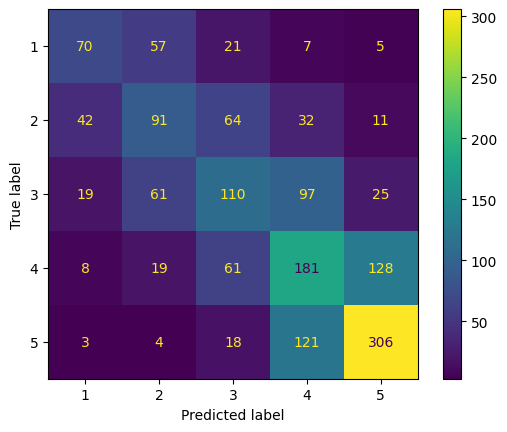

array([[ 70,  57,  21,   7,   5],
       [ 42,  91,  64,  32,  11],
       [ 19,  61, 110,  97,  25],
       [  8,  19,  61, 181, 128],
       [  3,   4,  18, 121, 306]])

In [137]:

y_mnb_pred = clf.predict(X_mnb_test)
cm = confusion_matrix(y_mnb_test, y_mnb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()
confusion_matrix(y_mnb_test,y_mnb_pred)

In [138]:
print(classification_report(y_mnb_test, y_mnb_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           1       0.49      0.44      0.46       160
           2       0.39      0.38      0.39       240
           3       0.40      0.35      0.38       312
           4       0.41      0.46      0.43       397
           5       0.64      0.68      0.66       452

    accuracy                           0.49      1561
   macro avg       0.47      0.46      0.46      1561
weighted avg       0.48      0.49      0.48      1561



Podemos ver que los valores de exactitud y de f1-score no son óptimos, ambos son de menos de 0.5 a pesar de probar con diferentes valores en los hiperparámetros, por lo que el modelo con este algortimo es deficiente. Viendo la matriz de confusión podemos ver que los resultados tienen sentido, pues al algoritmo confunde con frecuencia las reseñas de un grupo con las de grupos cercanos pero no es probable que confunda reseñas de calificación 5 con calificación 1.

## 4.2 Árbol de decisión

El segundo algoritmo a utilizar será el de clasificador con árboles de decisión. Este algoritmo aprende sobre los datos unas reglas simples con las que evalúa los datos a lo largo de diferentes nodos hasta llegar a una hoja con la clasificación. Cada nodo tienen unas reglas que definirán qué camino toman los datos nuevos a lo largo del árbol basados en los valores de sus variables. Estas reglas las genera el algoritmo calculando qué variables hacen particiones más puras de los datos. Utilizaremos los datos

In [139]:
# Split the data into training and testing sets
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tf_idf, y_data, test_size=0.2, random_state=42)

In [140]:
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 8, random_state=0)
arbol = arbol.fit(X_tree_train,y_tree_train)

Utilizaremos validación cruzada con Kfold para buscar los valores más ópitmos de los hiperparámetros. Dividiremos el conjunto en 10 pliegues y haremos la validación con dos criterios diferentes del algiritmo para decidir la mejor partición y con diferentes niveles de profundidad máxima en el árbol.

In [141]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20,30]}
arbol = DecisionTreeClassifier(random_state=0)
mejor_arbol = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_arbol.fit(X_tree_train, y_tree_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20, 30]})

In [142]:
mejor_arbol.best_params_

{'criterion': 'gini', 'max_depth': 30}

In [143]:
# Obtener el mejor modelo.
arbol_final = mejor_arbol.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_tree_train = arbol_final.predict(X_tree_train)
y_pred_tree_test = arbol_final.predict(X_tree_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_tree_train, y_pred_tree_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_tree_test, y_pred_tree_test))


print("Precisión: {}".format(precision_score(y_tree_test,y_pred_tree_test, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_tree_test,y_pred_tree_test, average='weighted')))


Exactitud sobre entrenamiento: 0.80
Exactitud sobre test: 0.35
Precisión: 0.3518836705749899
Puntuación F1: 0.3464500488600748


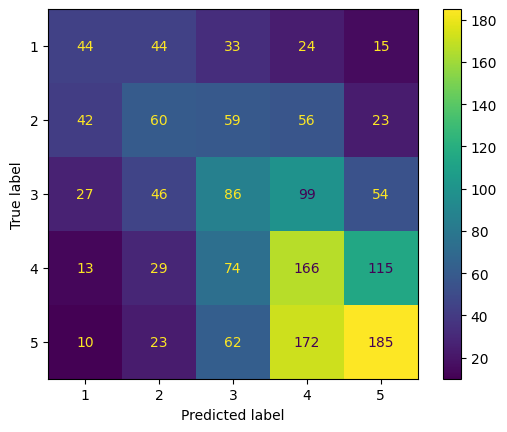

In [144]:
cm = confusion_matrix(y_tree_test,y_pred_tree_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

Nuevamente vemos que los valores de precisión y de exactitud para este nuevo algoritmo son mucho más bajos de lo requerido con los hiperparámetros que se calcularon como los mejores, por lo que este modelo también arroja valores deficientes y en su matriz de confusión vemos el mismo patrón que para el anterior algoritmo que dice que los errores se hicieron al confundir la calificación con valores cercanos.

## 4.3 Support Vector Machines

Las SVM son algoritmos especialmente buenos manejando espacios de variables de muchas dimensiones. El algoritmo calcula, con base en los datos ingresados, un hiperplano que separa los puntos en los diferentes grupos. El hiperparámetro más importante de este algoritmo es C, el cula define qué tan cerca está el hiperplano de los puntos del dataset, por lo que un valor más alto de C se ajustará más a los datos de entrenamiento. Luego de probar el valor default de C que es 1, vimos que se sigue cometiendo mucho el error de que los valores se confunden con valores de clases cercanas, por lo que usamos valores altos de C hasta el punto que aumentarlos no aumenta la exactitud sobre el test.

In [145]:
# Split the data into training and testing sets
X_svc_train, X_svc_test, y_svc_train, y_svc_test = train_test_split(X_tf_idf, y_data, test_size=0.2, random_state=42)

In [146]:
# Para crear el support vector machine
from sklearn.svm import SVC
svc = SVC(C=10)
svc = svc.fit(X_svc_train,y_svc_train)
# Probemos ahora este modelo sobre test.
y_pred_svc_train = svc.predict(X_svc_train)
y_pred_svc_test = svc.predict(X_svc_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_svc_train, y_pred_svc_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_svc_test, y_pred_svc_test))


print("Precisión: {}".format(precision_score(y_svc_test,y_pred_svc_test, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_svc_test,y_pred_svc_test, average='weighted')))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.49
Precisión: 0.48980939628222586
Puntuación F1: 0.4852040915124726


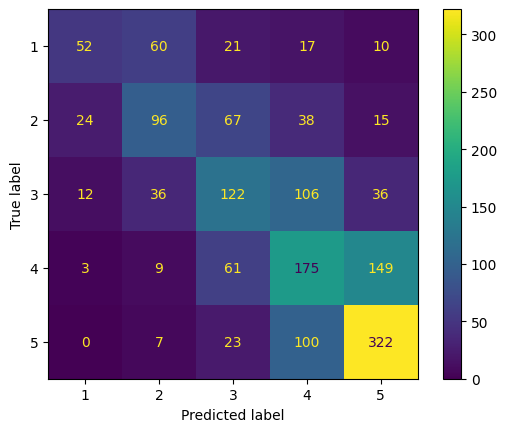

In [147]:
cm = confusion_matrix(y_svc_test,y_pred_svc_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

Vemos que los valores de precisión y de F1 aumentaron ligeramente frente a los algoritmos anteriores, llegando casi a 0.5. Igualmente, el algortimo sigue cometiendo los mismos errores de los algoritmos anteriores de asignar las reseñas a calificaciones cercanas a la real. A pesar de esto, el algoritmo sería útil para tener una primera idea de la calificación de una reseña pues tiende a seguir los patrones que hacen que una calificación sea más alta a pesar de no ser estrictamente preciso, probablemente por patrone smuy similares entre las reseñas de diferentes calificaciones.

## 4.4 Regresión Ridge

Al ver que los algoritmos de clasificación no están dando buenos resultados, se decidió intentar con un algoritmo de regresión. En vez de usar la regresión lineal, utlizaremos la regresión Ridge que mejor, que evita el sobreajuste que puede hacer la regresión lineal al tener muchas variables de entrada por medio de una regularización. Este algoritmo calculará un coeficiente para cada variable de entrada para estimar un valor de la calificación. Como este valor que estima será un número flotante y no un número entero, para la predicción de los valores redondearemos los resultados que nos haya dado la regresión para que queden en números enteros, también haremos que si son mayores a 5 queden fijados en 5, igual que si son menores a 1 queden fijados en 1.

In [148]:
# Split the data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_tf_idf, y_data, test_size=0.2, random_state=42)

In [149]:
# Para crear la regresión lineal
from sklearn.linear_model import Ridge
reg = Ridge(alpha=0.7)
reg = reg.fit(X_reg_train,y_reg_train)
# Probemos ahora este modelo sobre test.
y_pred_reg_train = reg.predict(X_reg_train)
y_pred_reg_test = reg.predict(X_reg_test)
for x in range(y_pred_reg_test.size): #Aproximar los valores dados por la regresión
    if y_pred_reg_test[x] > 5:
        y_pred_reg_test[x] = 5
    elif y_pred_reg_test[x] < 1:
        y_pred_reg_test[x] = 1
    else:
        y_pred_reg_test[x] = round(y_pred_reg_test[x])
y_pred_reg_test =y_pred_reg_test.astype('i')

print('Exactitud sobre test: %.2f' % accuracy_score(y_reg_test, y_pred_reg_test))


print("Precisión: {}".format(precision_score(y_reg_test,y_pred_reg_test, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_reg_test,y_pred_reg_test, average='weighted')))

Exactitud sobre test: 0.42
Precisión: 0.4987005044478485
Puntuación F1: 0.41035618826372494


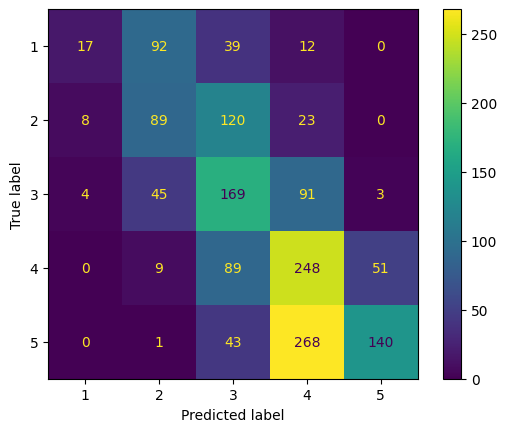

In [150]:
cm = confusion_matrix(y_reg_test,y_pred_reg_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

Vemos que nuevamente hubo un gran porcetaje de error en las predicciones, especialmente en valores de calificación 4 que se llevaron a calificación 5, por lo que este modelo sigue teniendo unas métricas un poco peores que las de la Support Vector Machine

## 4.5 Random forest


Random Forest es un algoritmo de aprendizaje supervisado que pertenece a la categoría de algoritmos de ensemble y se utiliza para tareas de clasificación y regresión. Durante el entrenamiento, construye un conjunto de árboles de decisión utilizando un subconjunto aleatorio de características y ejemplos de entrenamiento seleccionados mediante bootstrap sampling. Luego, durante la fase de predicción, cada árbol emite una predicción y la clase final se determina por votación (en clasificación) o por promedio (en regresión) de las predicciones individuales de los árboles. Random Forest es robusto ante datos ruidosos, maneja automáticamente la selección de características y reduce el riesgo de sobreajuste al construir múltiples árboles y promediar sus predicciones. Su capacidad para manejar datos variados y su relativa facilidad de uso lo hacen adecuado para proyectos de análisis de sentimientos, donde puede evaluar opiniones diversas y expresiones idiomáticas en reseñas.

In [151]:
from sklearn.ensemble import RandomForestClassifier

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_count, y_data, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_rf_train, y_rf_train)

y_pred_rf_train = rf.predict(X_rf_train)
y_pred_rf_test = rf.predict(X_rf_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_rf_train, y_pred_rf_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_rf_test, y_pred_rf_test))


print("Precisión: {}".format(precision_score(y_rf_test,y_pred_rf_test, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_rf_test,y_pred_rf_test, average='weighted')))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.44
Precisión: 0.444240169810969
Puntuación F1: 0.4222268681592014


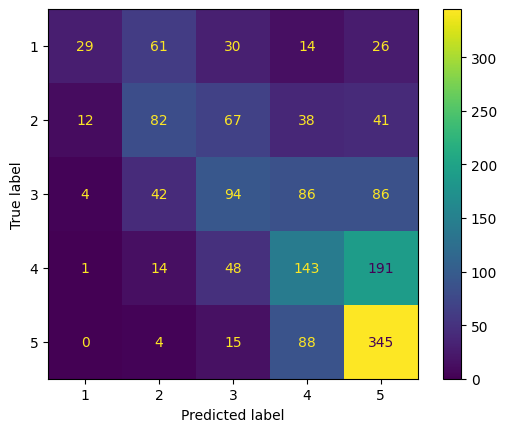

In [152]:
cm = confusion_matrix(y_rf_test,y_pred_rf_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()


Los resultados obtenidos para el modelo de Random Forest muestran una discrepancia notable entre la exactitud en el conjunto de entrenamiento y la exactitud en el conjunto de prueba. Esta discrepancia sugiere que el modelo puede estar sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos. La precisión y la puntuación F1 son relativamente bajas, lo que indica que el modelo tiene dificultades para clasificar correctamente las reseñas en todas las categorías de sentimiento. La matriz de confusión muestra que el modelo tiende a clasificar incorrectamente las reseñas, con una distribución desigual de las predicciones en las diferentes categorías de sentimiento. En resumen, los resultados sugieren que el modelo de Random Forest necesita ajustes para mejorar su capacidad de generalización y precisión en la clasificación de las reseñas de sentimientos.